<a href="https://colab.research.google.com/github/Hadeer-Youssef/OCR_Practic/blob/main/solution_task2(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# solution Task2

In [ ]:
import cv2
import numpy as np
from google.colab import drive
import glob as glob
import matplotlib.pyplot as plt
import os
#import pytesseract

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Task_2:
 _  We want you to build a computer vision model which takes the  attached images
“test_image_0.jpg and test_image_1.jpg ” as an input to your model and the expected output is
all the text informations in the given images .
"Please do not do any manual rotation on the attached images ."

_  Explain all the challenges you encountered in solving this task .


In [ ]:
#pytesseract.pytesseract.tesseract_cmd=r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [ ]:
!pip install ArabicOcr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 14.2 MB/s eta 0:00:00


In [ ]:
from ArabicOcr import arabicocr

# image Preprocessing

we can preprocessing and alignment for images with many method

1.method (1) we using Cropping and perspective restoration by use rectangle points to calculate destination points of the images with mouse points

In [ ]:
path1=r"/content/gdrive/MyDrive/assessement_task3_chield/input_image"

In [ ]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
circles = np.zeros((4, 2), np.int32)
counter = 0

def mousePoints(event, x, y, flags, params):
        global counter
        if event == cv2.EVENT_LBUTTONDOWN:
              if counter < 4:
                circles[counter] = x, y
                counter += 1
                print(circles)


for img_path in glob.glob(os.path.join(path1, "*.jpg")) + glob.glob(os.path.join(path1, "*.png")):
        label = img_path.split("\\")[-1]
        img1 = cv2.imread(img_path)
        gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points in the largest contour
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Crop the image using the extreme points
        cropped_image = img1[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
        new_resized= cropped_image.copy()
        resized_image = cv2.resize(new_resized, (600, 600))
        # Perform warpPerspective transformation to align the cropped image
        width, height = 600, 600

        if resized_image.shape[0] > 0 and resized_image.shape[1] > 0:
            while True:
                if counter == 4:
                    pts1 = np.float32([circles[0], circles[1], circles[2], circles[3]])
                    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
                    M = cv2.getPerspectiveTransform(pts1, pts2)
                    aligned_image = cv2.warpPerspective(resized_image, M, (width, height))

                     # Save the aligned image to the output folder
                    output_folder=r"F:\my course of AI for Fatma\Computer Vision Assignment\Computer Vision Assignment\Task2\input_images\aligment_images"
                    filename = os.path.splitext(label)[0] + "_aligned.jpg"
                    save_path = os.path.join(output_folder, filename)
                    cv2.imwrite(save_path, aligned_image)



                    cv2.imshow("Aligned Image", aligned_image)
                    counter = 0  # Reset counter after transformation

                for i in range(0, 4):
                    cv2.circle(resized_image, (circles[i][0], circles[i][1]), 5, (0, 0, 255), cv2.FILLED)

                cv2.imshow('Cropped Image', resized_image)
               # cv2.namedWindow("Cropped Image")
                cv2.setMouseCallback("Cropped Image", mousePoints)

                k = cv2.waitKey(1)
                if k == 27:  # Press 'Esc' to exit the loop
                    break
        else:
            print(f"Invalid image: {img_path}")

cv2.destroyAllWindows()

[[34 50]
 [ 0  0]
 [ 0  0]
 [ 0  0]]
[[ 34  50]
 [554  13]
 [  0   0]
 [  0   0]]
[[ 34  50]
 [554  13]
 [ 13 575]
 [  0   0]]
[[ 34  50]
 [554  13]
 [ 13 575]
 [585 561]]
[[ 47 555]
 [554  13]
 [ 13 575]
 [585 561]]
[[ 47 555]
 [ 10  56]
 [ 13 575]
 [585 561]]
[[ 47 555]
 [ 10  56]
 [574 575]
 [585 561]]
[[ 47 555]
 [ 10  56]
 [574 575]
 [562  24]]


2.method (2) we using Cropping Deskewing algorithm ,main goal will be splitting the rotated image into text blocks, and determining the angle from them after the skew angle is obtained we just need to re-rotate our image

In [ ]:
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    #(30,5)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 7))
    #(5)
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour  = max(contours, key=cv2.contourArea)
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    #cv2.imwrite("boxes.jpg", newImage)
    #display(boxes.jpg)
     # Save the image with bounding boxes
    #output_with_boxes_path = f"output_with_boxes_{os.path.splitext(os.path.basename(input_image_path))[0]}.jpg"
    #cv2.imwrite(output_with_boxes_path, newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    #allContourAngles = [cv2.minAreaRect(c)[-1] for c in contours]
    #angle = sum(allContourAngles) / len(allContourAngles)
    print(angle )
    if angle < 270:
        angle = (180 + angle)
    return 1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [ ]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, 1.0 * angle)

we need make rotation for "test_image_1.jpg" so we call Deskewing algorithm and adjust angle to suitable with my image  

In [ ]:
test_image_1_correct= cv2.imread(r"F:\my course of AI for Fatma\Computer Vision Assignment\Computer Vision Assignment\Task2\input_images\test_image_1.jpg")


In [ ]:
test_image_1_fixed_rotate = deskew(test_image_1_correct)
#print (test_image_1_fixed_rotate)
cv2.imshow("test_image_1_fixed_rotate",test_image_1_fixed_rotate)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite(r"F:\my course of AI for Fatma\Computer Vision Assignment\Computer Vision Assignment\Task2\input_images\test_image_1_fixed_rotate.jpg", test_image_1_fixed_rotate)

28
90.0


True

then making cropping for modified input images  

In [ ]:
def cropping(path):
    cropped_list=[]
    for img_path in glob.glob(os.path.join(path, "*.jpg")) :
        label = img_path.split("\\")[-1]
        img1 = cv2.imread(img_path)
        gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points in the largest contour
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # Crop the image using the extreme points
        cropped_image = img1[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
        cropped_list.append([cropped_image,label])
         # Save the cropped image to the output folder crop
        output_folder=r"F:\my course of AI for Fatma\Computer Vision Assignment\Computer Vision Assignment\Task2\input_images\input_after_rotation\cropping_images_with_modify_rotation"
        filename = os.path.splitext(label)[0] + "cropped.jpg"
        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, cropped_image)
        new_resized= cropped_image.copy()
        #resized_image = cv2.resize(new_resized, (600, 600))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                                                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('original_image')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(cropped_image,cv2.COLOR_BGR2RGB))
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,
                                                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('cropped_image')
        plt.show()

    return cropped_list


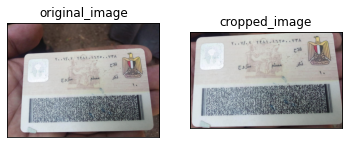

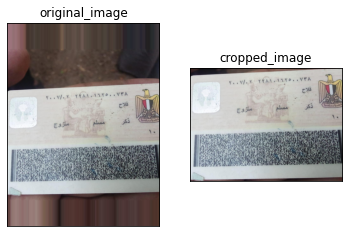

In [ ]:
path2=r"F:\my course of AI for Fatma\Computer Vision Assignment\Computer Vision Assignment\Task2\input_images\input_after_rotation"
cropping_input_images=cropping(path2)

In [ ]:

#import pytesseract

input_image_paths_cropped_path = r"/content/gdrive/MyDrive/assessement_task3_chield/id_images"
output_folder = r"/content/gdrive/MyDrive/assessement_task3_chield/output_id_info"

# Initialize counters
i = 0
j = 0
f = 0

for input_image_path in glob.glob(os.path.join(input_image_paths_cropped_path, "*.jpg")):
    # Load the input image
    image = cv2.imread(input_image_path)
    newImage = image.copy()

    # Convert the image to grayscale and apply preprocessing
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for c in contours:
        rect = cv2.boundingRect(c)
        x, y, w, h = rect
        if (w * h > 2000) and (w * h < 20000):
            # Extract the ROI from the image
            roi = image[y:y + h, x:x + w]

            # Save the extracted ROI
            filename_roi = os.path.splitext(os.path.basename(input_image_path))[0] + f"_roi_{i}.jpg"
            save_path_roi = os.path.join(output_folder, filename_roi)
            cv2.imwrite(save_path_roi, roi)
            i += 1
            # Perform OCR on the ROI
            out_image = 'out.jpg'
            results = arabicocr.arabic_ocr(save_path_roi, out_image)

            # Extract text from results and save to a text file
            words = [result[1] for result in results]
            output_txt_path = os.path.splitext(os.path.basename(input_image_path))[0]+f"extracted_text_{f}.txt"
            save_path_txt = os.path.join(output_folder, output_txt_path)
            with open(save_path_txt, 'w', encoding='utf-8') as txt_file:
                txt_file.write('\n'.join(words))

            f += 1

            # Draw bounding box
            cv2.rectangle(newImage, (x, y), (x + w, y + h), (0, 255, 0), 2)
    f=0
    i=0
    # Save the image with bounding boxes
    filename_boxes = os.path.splitext(os.path.basename(input_image_path))[0] + f"_boxes_{j}.jpg"
    save_path_boxes = os.path.join(output_folder, filename_boxes)
    cv2.imwrite(save_path_boxes, newImage)
    j += 1

cv2.destroyAllWindows()


[INFO] OCR'ing input image...


[INFO] 0.6322: ٠ ٥ ٢ ٦ ١ ٠ ١ ٨
[INFO] 0.9999: ٧٣٨
[INFO] OCR'ing input image...


[INFO] OCR'ing input image...


[INFO] 0.9756: متزوج
[INFO] OCR'ing input image...


[INFO] 0.6774: فلا
[INFO] OCR'ing input image...


[INFO] 0.9572: مسلم
[INFO] OCR'ing input image...


[INFO] 0.9530: ذكر
[INFO] OCR'ing input image...


[INFO] OCR'ing input image...


[INFO] 0.6609: ٠ ٥ ٢ ٦ ١ ٠ ٨١
[INFO] 0.9999: ٧٣٨
[INFO] OCR'ing input image...


[INFO] OCR'ing input image...


[INFO] 0.9880: متزوج
[INFO] OCR'ing input image...


[INFO] 0.8935: فلا
[INFO] OCR'ing input image...


[INFO] 0.9999: مسلم
[INFO] OCR'ing input image...


[INFO] 0.9689: ذكر
[INFO] OCR'ing input image...


In [ ]:
from google.colab.patches import cv2_imshow

[INFO] OCR'ing input image...
[INFO] 0.6322: ٠ ٥ ٢ ٦ ١ ٠ ١ ٨
[INFO] 0.9999: ٧٣٨
[[[[62, 3], [253, 3], [253, 44], [62, 44]], '٠ ٥ ٢ ٦ ١ ٠ ١ ٨', 0.6321856519533229], [[[276, 2], [350, 2], [350, 34], [276, 34]], '٧٣٨', 0.9999177539622263]]


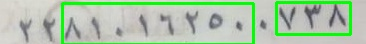

-1

In [ ]:
image_path='/content/test_image_1roi.jpg'
out_image='out.jpg'
results=arabicocr.arabic_ocr(image_path,out_image)
print(results)
words=[]
for i in range(len(results)):
		word=results[i][1]
		words.append(word)
with open ('file.txt','w',encoding='utf-8')as myfile:
		myfile.write(str(words))
import cv2
img = cv2.imread('out.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
cv2.waitKey(0)
